# Segmentation of nuclei using image processing

## aims

In this tutorial you will 
- Load an image of nuclei from folder
- Segment using ASTROPY
- Calculate region properties
- Plot distributions of set of properties

## installation

You need to make sure you have 

- skimage

installed. To install, run:

with pip:

```
pip install scikit-image
```

or with conda:
```
conda install scikit-image
```

## warnings 

Make sure MPLBACKEND is not defined as `agg` otherwise you will see no graphical output!
To make sure of this, run the following command before invoking `jupyter lab`:

```sh
export MPLBACKEND=
```

## credits

Marcelo Nollmann, June 2021


In [1]:
# loads packages

from tifffile import imsave
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import imageio
from scipy import ndimage

In [2]:
# loads image
fileName = 'data/Image_nuclei_2D.tif'
img = io.imread(fileName).squeeze()
print("Image read: {}".format(fileName))
print("Image size: {}".format(img.shape))


Image read: data/Image_nuclei_2D.tif
Image size: (2048, 2048)


In [6]:
from photutils import detect_threshold,detect_sources, Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

threshold_over_std = 1.0
fwhm = 3.0
area_min = 20

threshold = detect_threshold(img, nsigma=2.0)
sigma_clip = SigmaClip(sigma=3.0)

bkg_estimator = MedianBackground()
bkg = Background2D(img, (64, 64), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,)
threshold = bkg.background + (
    threshold_over_std * bkg.background_rms
)  # background-only error image, typically 1.0

sigma = fwhm * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()

# estimates masks and deblends
#kernel = make_2dgaussian_kernel(3.0, size=3)  # FWHM = 3.
convolved_data = convolve(img, kernel)
segm = detect_sources(convolved_data, threshold, npixels=area_min)

#segm = detect_sources(img, threshold, npixels=area_min, filter_kernel=kernel,)
print("Done segmenting!")

/tmp/ipykernel_42342/2618464874.py:1: DeprecationWarning: `photutils.detect_threshold` is a deprecated alias for `photutils.segmentation.detect_threshold` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_threshold` to silence this warning.
  from photutils import detect_threshold,detect_sources, Background2D, MedianBackground
/tmp/ipykernel_42342/2618464874.py:1: DeprecationWarning: `photutils.detect_sources` is a deprecated alias for `photutils.segmentation.detect_sources` and will be removed in the future. Instead, please use `from photutils.segmentation import detect_sources` to silence this warning.
  from photutils import detect_threshold,detect_sources, Background2D, MedianBackground
/tmp/ipykernel_42342/2618464874.py:1: DeprecationWarning: `photutils.Background2D` is a deprecated alias for `photutils.background.Background2D` and will be removed in the future. Instead, please use `from photutils.background import Background2D` to s

Done segmenting!


In [7]:
# post-process the binary mask and compute labels
from skimage import filters, measure, morphology

mask=segm.data > 0
area_min = 100
#threshold = filters.threshold_otsu(img)
#mask = img > threshold
mask = morphology.remove_small_objects(mask, area_min)
mask = morphology.remove_small_holes(mask, area_min)
labels = measure.label(mask)

# calculate object properties
props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'mean_intensity']
print("Calculated {} properties for {} objects".format(len(properties),labels.max()))

Calculated 4 properties for 620 objects


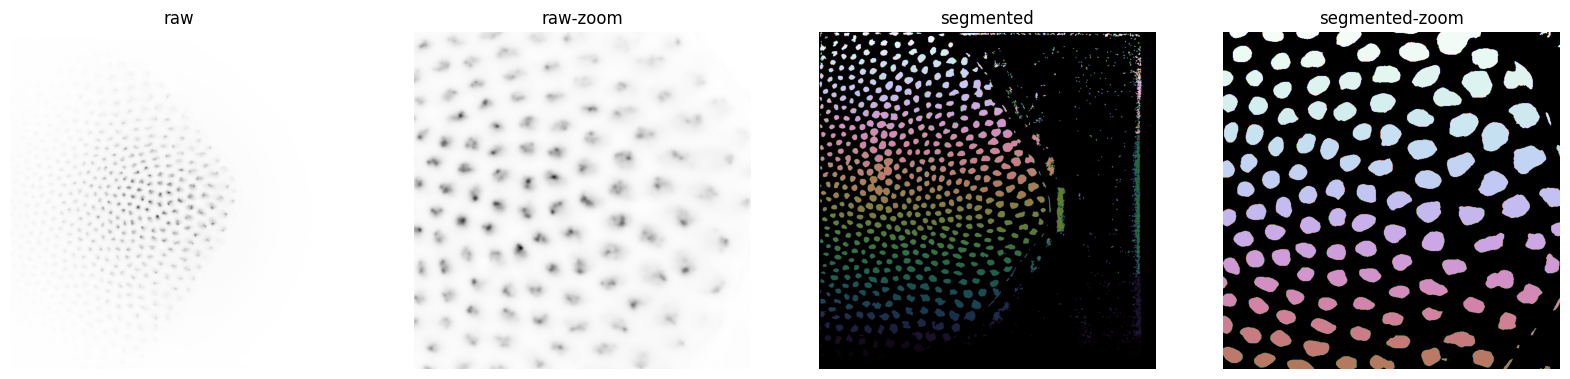

In [8]:
# displays images
cmap = 'cubehelix'
fig, axes = plt.subplots(1, 4)
ax = axes.ravel()
fig.set_size_inches((5*4, 5))

# Cropping
lx, ly = img.shape
zoom = 3
crop_img = img[lx // zoom: - lx // zoom, ly // zoom: - ly // zoom]
crop_segm = segm.data[lx // zoom: - lx // zoom, ly // zoom: - ly // zoom]

ax[0].imshow(img, cmap='Greys')
ax[1].imshow(crop_img, cmap='Greys')
ax[2].imshow(segm.data, origin="lower", cmap=cmap, alpha=1)
ax[3].imshow(crop_segm, origin="lower", cmap=cmap, alpha=1)

subtitles=['raw','raw-zoom','segmented','segmented-zoom']

for axis,subtitle in zip(ax,subtitles):
    axis.set_title(subtitle)
    axis.axis('off')


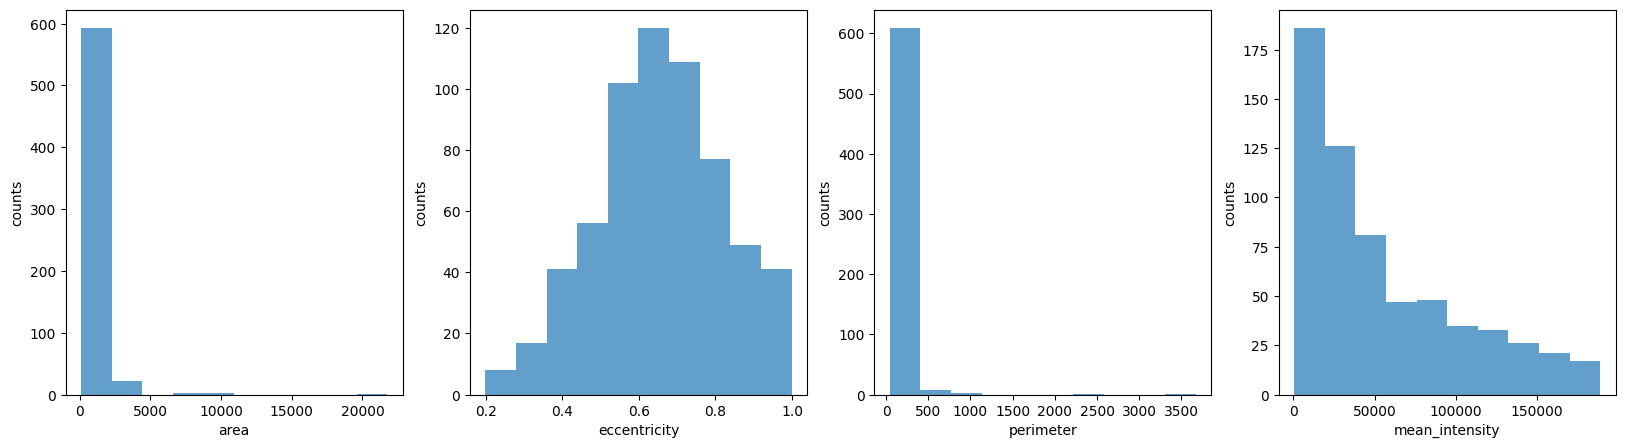

In [9]:
# to code
area=[x.area for x in props]
eccentricity=[x.eccentricity for x in props]
perimeter=[x.perimeter for x in props]
mean_intensity=[x.mean_intensity for x in props]
property_list = [area,eccentricity,perimeter,mean_intensity]

fig, axes = plt.subplots(1, 4)
ax = axes.ravel()
fig.set_size_inches((5*4, 5))

for axis,property_label,property in zip(ax,properties,property_list):
    axis.hist(property,alpha=.7)
    axis.set_xlabel(property_label)
    axis.set_ylabel("counts")
